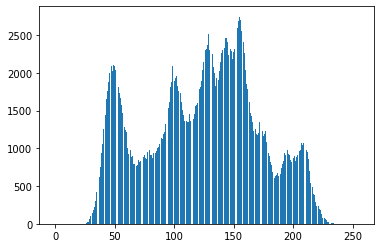

18362
106045
2048
644
1490
[2688, 2683, 1420, 1678, 2351]
pos are 0 0
pos are 0 1
pos are 0 2
pos are 0 3
pos are 0 4
pos are 0 5
pos are 0 6
pos are 0 7
pos are 0 8
pos are 0 9
pos are 0 10
pos are 0 11
pos are 0 12
pos are 0 13
pos are 0 14
pos are 0 15
pos are 0 16
pos are 0 17
pos are 0 18
pos are 0 19
pos are 0 20
pos are 0 21
pos are 0 22
pos are 0 23
pos are 0 24
pos are 0 25
pos are 0 26
pos are 0 27
pos are 0 28
pos are 0 29
pos are 0 30
pos are 0 31
pos are 0 32
pos are 0 33
pos are 0 34
pos are 0 35
pos are 0 36
pos are 0 37
pos are 0 38
pos are 0 39
pos are 0 40
pos are 0 41
pos are 0 42
pos are 0 43
pos are 0 44
pos are 0 45
pos are 0 46
pos are 0 47
pos are 0 48
pos are 0 49
pos are 0 50
pos are 0 51
pos are 0 52
pos are 0 53
pos are 0 54
pos are 0 55
pos are 0 56
pos are 0 57
pos are 0 58
pos are 0 59
pos are 0 60
pos are 1 0
pos are 1 1
pos are 1 2
pos are 1 3
pos are 1 4
pos are 1 5
pos are 1 6
pos are 1 7
pos are 1 8
pos are 1 9
pos are 1 10
pos are 1 11
pos are 1 12


pos are 14 45
pos are 14 46
pos are 14 47
pos are 14 48
pos are 14 49
pos are 14 50
pos are 14 51
pos are 14 52
pos are 14 53
pos are 14 54
pos are 14 55
pos are 14 56
pos are 14 57
pos are 14 58
pos are 14 59
pos are 15 0
pos are 15 1
pos are 15 2
pos are 15 3
pos are 15 4
pos are 15 5
pos are 15 6
pos are 15 7
pos are 15 8
pos are 15 9
pos are 15 10
pos are 15 11
pos are 15 12
pos are 15 13
pos are 15 14
pos are 15 15
pos are 15 16
pos are 15 17
pos are 15 18
pos are 15 19
pos are 15 20
pos are 15 21
pos are 15 22
pos are 15 23
pos are 15 24
pos are 15 25
pos are 15 26
pos are 15 27
pos are 15 28
pos are 15 29
pos are 15 30
pos are 15 31
pos are 15 32
pos are 15 33
pos are 15 34
pos are 15 35
pos are 15 36
pos are 15 37
pos are 15 38
pos are 15 39
pos are 15 40
pos are 15 41
pos are 15 42
pos are 15 43
pos are 15 44
pos are 15 45
pos are 15 46
pos are 15 47
pos are 15 48
pos are 15 49
pos are 15 50
pos are 15 51
pos are 15 52
pos are 15 53
pos are 15 54
pos are 15 55
pos are 15 56
po

pos are 32 44
pos are 32 45
pos are 32 46
pos are 32 47
pos are 32 48
pos are 32 49
pos are 32 50
pos are 32 51
pos are 32 52
pos are 32 53
pos are 32 54
pos are 32 55
pos are 32 56
pos are 32 57
pos are 32 58
pos are 32 59
pos are 32 60
pos are 33 0
pos are 33 1
pos are 33 2
pos are 33 3
pos are 33 4
pos are 33 5
pos are 33 6
pos are 33 7
pos are 33 8
pos are 33 9
pos are 33 10
pos are 33 11
pos are 33 12
pos are 33 13
pos are 33 14
pos are 33 15
pos are 33 16
pos are 33 17
pos are 33 18
pos are 33 19
pos are 33 20
pos are 33 21
pos are 33 22
pos are 33 23
pos are 33 24
pos are 33 25
pos are 33 26
pos are 33 27
pos are 33 28
pos are 33 29
pos are 33 30
pos are 33 31
pos are 33 32
pos are 33 33
pos are 33 34
pos are 33 35
pos are 33 36
pos are 33 37
pos are 33 38
pos are 33 39
pos are 33 40
pos are 33 41
pos are 33 42
pos are 33 43
pos are 33 44
pos are 33 45
pos are 33 46
pos are 33 47
pos are 33 48
pos are 33 49
pos are 33 50
pos are 33 51
pos are 33 52
pos are 33 53
pos are 33 54
po

pos are 50 16
pos are 50 17
pos are 50 18
pos are 50 19
pos are 50 20
pos are 50 21
pos are 50 22
pos are 50 23
pos are 50 24
pos are 50 25
pos are 50 26
pos are 50 27
pos are 50 28
pos are 50 29
pos are 50 30
pos are 50 31
pos are 50 32
pos are 50 33
pos are 50 34
pos are 50 35
pos are 50 36
pos are 50 37
pos are 50 38
pos are 50 39
pos are 50 40
pos are 50 41
pos are 50 42
pos are 50 43
pos are 50 44
pos are 50 45
pos are 50 46
pos are 50 47
pos are 50 48
pos are 50 49
pos are 50 50
pos are 50 51
pos are 50 52
pos are 50 53
pos are 50 54
pos are 50 55
pos are 50 56
pos are 50 57
pos are 50 58
pos are 50 59
pos are 50 60
pos are 51 0
pos are 51 1
pos are 51 2
pos are 51 3
pos are 51 4
pos are 51 5
pos are 51 6
pos are 51 7
pos are 51 8
pos are 51 9
pos are 51 10
pos are 51 11
pos are 51 12
pos are 51 13
pos are 51 14
pos are 51 15
pos are 51 16
pos are 51 17
pos are 51 18
pos are 51 19
pos are 51 20
pos are 51 21
pos are 51 22
pos are 51 23
pos are 51 24
pos are 51 25
pos are 51 26
po

pos are 66 47
pos are 66 48
pos are 66 49
pos are 66 50
pos are 66 51
pos are 66 52
pos are 66 53
pos are 66 54
pos are 66 55
pos are 66 56
pos are 66 57
pos are 66 58
pos are 66 59
pos are 67 0
pos are 67 1
pos are 67 2
pos are 67 3
pos are 67 4
pos are 67 5
pos are 67 6
pos are 67 7
pos are 67 8
pos are 67 9
pos are 67 10
pos are 67 11
pos are 67 12
pos are 67 13
pos are 67 14
pos are 67 15
pos are 67 16
pos are 67 28
pos are 67 29
pos are 67 30
pos are 67 31
pos are 67 32
pos are 67 33
pos are 67 34
pos are 67 35
pos are 67 36
pos are 67 37
pos are 67 38
pos are 67 39
pos are 67 40
pos are 67 41
pos are 67 42
pos are 67 43
pos are 67 44
pos are 67 45
pos are 67 46
pos are 67 47
pos are 67 48
pos are 67 49
pos are 67 50
pos are 67 51
pos are 67 52
pos are 67 53
pos are 67 54
pos are 67 55
pos are 67 56
pos are 67 57
pos are 67 58
pos are 67 59
pos are 67 60
pos are 68 0
pos are 68 1
pos are 68 2
pos are 68 3
pos are 68 4
pos are 68 5
pos are 68 6
pos are 68 7
pos are 68 8
pos are 68 

pos are 93 53
pos are 93 54
pos are 93 55
pos are 93 56
pos are 93 57
pos are 93 58
pos are 94 29
pos are 94 30
pos are 94 31
pos are 94 32
pos are 94 33
pos are 94 34
pos are 94 35
pos are 94 36
pos are 94 37
pos are 94 38
pos are 94 39
pos are 94 40
pos are 94 41
pos are 94 42
pos are 94 43
pos are 94 44
pos are 94 45
pos are 94 46
pos are 94 47
pos are 94 48
pos are 94 49
pos are 94 50
pos are 94 51
pos are 94 52
pos are 94 53
pos are 94 54
pos are 94 55
pos are 94 56
pos are 94 57
pos are 94 58
pos are 95 28
pos are 95 29
pos are 95 30
pos are 95 31
pos are 95 32
pos are 95 33
pos are 95 34
pos are 95 35
pos are 95 36
pos are 95 37
pos are 95 38
pos are 95 39
pos are 95 40
pos are 95 41
pos are 95 42
pos are 95 43
pos are 95 44
pos are 95 45
pos are 95 46
pos are 95 47
pos are 95 48
pos are 95 49
pos are 95 50
pos are 95 51
pos are 95 52
pos are 95 53
pos are 95 54
pos are 95 55
pos are 95 56
pos are 95 57
pos are 95 58
pos are 96 28
pos are 96 29
pos are 96 30
pos are 96 31
pos ar

pos are 125 31
pos are 125 32
pos are 125 33
pos are 125 34
pos are 125 35
pos are 125 36
pos are 125 37
pos are 125 38
pos are 125 39
pos are 125 40
pos are 125 41
pos are 125 42
pos are 125 43
pos are 125 44
pos are 125 45
pos are 125 46
pos are 125 47
pos are 125 48
pos are 125 49
pos are 125 50
pos are 125 51
pos are 125 52
pos are 125 53
pos are 125 54
pos are 125 55
pos are 125 56
pos are 125 57
pos are 125 58
pos are 125 59
pos are 126 30
pos are 126 31
pos are 126 32
pos are 126 33
pos are 126 34
pos are 126 35
pos are 126 36
pos are 126 37
pos are 126 38
pos are 126 39
pos are 126 40
pos are 126 41
pos are 126 42
pos are 126 43
pos are 126 44
pos are 126 45
pos are 126 46
pos are 126 47
pos are 126 48
pos are 126 49
pos are 126 50
pos are 126 51
pos are 126 52
pos are 126 53
pos are 126 54
pos are 126 55
pos are 126 56
pos are 126 57
pos are 126 58
pos are 126 59
pos are 127 29
pos are 127 30
pos are 127 31
pos are 127 32
pos are 127 33
pos are 127 34
pos are 127 35
pos are 12

pos are 159 51
pos are 159 52
pos are 159 53
pos are 159 54
pos are 159 55
pos are 159 56
pos are 159 57
pos are 159 58
pos are 159 59
pos are 159 60
pos are 160 29
pos are 160 30
pos are 160 31
pos are 160 32
pos are 160 33
pos are 160 34
pos are 160 35
pos are 160 36
pos are 160 37
pos are 160 38
pos are 160 39
pos are 160 40
pos are 160 41
pos are 160 42
pos are 160 43
pos are 160 44
pos are 160 45
pos are 160 46
pos are 160 47
pos are 160 48
pos are 160 49
pos are 160 50
pos are 160 51
pos are 160 52
pos are 160 53
pos are 160 54
pos are 160 55
pos are 160 56
pos are 160 57
pos are 160 58
pos are 160 59
pos are 161 28
pos are 161 29
pos are 161 30
pos are 161 31
pos are 161 32
pos are 161 33
pos are 161 34
pos are 161 35
pos are 161 36
pos are 161 37
pos are 161 38
pos are 161 39
pos are 161 40
pos are 161 41
pos are 161 42
pos are 161 43
pos are 161 44
pos are 161 45
pos are 161 46
pos are 161 47
pos are 161 48
pos are 161 49
pos are 161 50
pos are 161 51
pos are 161 52
pos are 16

pos are 183 41
pos are 183 42
pos are 183 43
pos are 183 44
pos are 183 45
pos are 183 46
pos are 183 47
pos are 183 48
pos are 183 49
pos are 183 50
pos are 183 51
pos are 183 52
pos are 183 53
pos are 183 54
pos are 183 55
pos are 183 56
pos are 183 57
pos are 183 58
pos are 183 59
pos are 183 60
pos are 184 28
pos are 184 29
pos are 184 30
pos are 184 31
pos are 184 32
pos are 184 33
pos are 184 34
pos are 184 35
pos are 184 36
pos are 184 37
pos are 184 38
pos are 184 39
pos are 184 40
pos are 184 41
pos are 184 42
pos are 184 43
pos are 184 44
pos are 184 45
pos are 184 46
pos are 184 47
pos are 184 48
pos are 184 49
pos are 184 50
pos are 184 51
pos are 184 52
pos are 184 53
pos are 184 54
pos are 184 55
pos are 184 56
pos are 184 57
pos are 184 58
pos are 184 59
pos are 184 60
pos are 185 27
pos are 185 28
pos are 185 29
pos are 185 30
pos are 185 31
pos are 185 32
pos are 185 33
pos are 185 34
pos are 185 35
pos are 185 36
pos are 185 37
pos are 185 38
pos are 185 39
pos are 18

pos are 215 51
pos are 215 52
pos are 215 53
pos are 215 54
pos are 215 55
pos are 215 56
pos are 215 57
pos are 215 58
pos are 215 59
pos are 215 60
pos are 215 61
pos are 216 30
pos are 216 31
pos are 216 32
pos are 216 33
pos are 216 34
pos are 216 35
pos are 216 36
pos are 216 37
pos are 216 38
pos are 216 39
pos are 216 40
pos are 216 41
pos are 216 42
pos are 216 43
pos are 216 44
pos are 216 45
pos are 216 46
pos are 216 47
pos are 216 48
pos are 216 49
pos are 216 50
pos are 216 51
pos are 216 52
pos are 216 53
pos are 216 54
pos are 216 55
pos are 216 56
pos are 216 57
pos are 216 58
pos are 216 59
pos are 216 60
pos are 216 61
pos are 217 30
pos are 217 31
pos are 217 32
pos are 217 33
pos are 217 34
pos are 217 35
pos are 217 36
pos are 217 37
pos are 217 38
pos are 217 39
pos are 217 40
pos are 217 41
pos are 217 42
pos are 217 43
pos are 217 44
pos are 217 45
pos are 217 46
pos are 217 47
pos are 217 48
pos are 217 49
pos are 217 50
pos are 217 51
pos are 217 52
pos are 21

pos are 250 38
pos are 250 39
pos are 250 40
pos are 250 41
pos are 250 42
pos are 250 43
pos are 250 44
pos are 250 45
pos are 250 46
pos are 250 47
pos are 250 48
pos are 250 49
pos are 250 50
pos are 250 51
pos are 250 52
pos are 250 53
pos are 250 54
pos are 250 55
pos are 250 56
pos are 250 57
pos are 250 58
pos are 250 59
pos are 250 60
pos are 250 61
pos are 251 30
pos are 251 31
pos are 251 32
pos are 251 33
pos are 251 34
pos are 251 35
pos are 251 36
pos are 251 37
pos are 251 38
pos are 251 39
pos are 251 40
pos are 251 41
pos are 251 42
pos are 251 43
pos are 251 44
pos are 251 45
pos are 251 46
pos are 251 47
pos are 251 48
pos are 251 49
pos are 251 50
pos are 251 51
pos are 251 52
pos are 251 53
pos are 251 54
pos are 251 55
pos are 251 56
pos are 251 57
pos are 251 58
pos are 251 59
pos are 251 60
pos are 251 61
pos are 252 30
pos are 252 31
pos are 252 32
pos are 252 33
pos are 252 34
pos are 252 35
pos are 252 36
pos are 252 37
pos are 252 38
pos are 252 39
pos are 25

pos are 281 53
pos are 281 54
pos are 281 55
pos are 281 56
pos are 281 57
pos are 281 58
pos are 281 59
pos are 281 60
pos are 281 61
pos are 281 62
pos are 282 31
pos are 282 32
pos are 282 33
pos are 282 34
pos are 282 35
pos are 282 36
pos are 282 37
pos are 282 38
pos are 282 39
pos are 282 40
pos are 282 41
pos are 282 42
pos are 282 43
pos are 282 44
pos are 282 45
pos are 282 46
pos are 282 47
pos are 282 48
pos are 282 49
pos are 282 50
pos are 282 51
pos are 282 52
pos are 282 53
pos are 282 54
pos are 282 55
pos are 282 56
pos are 282 57
pos are 282 58
pos are 282 59
pos are 282 60
pos are 282 61
pos are 282 62
pos are 283 31
pos are 283 32
pos are 283 33
pos are 283 34
pos are 283 35
pos are 283 36
pos are 283 37
pos are 283 38
pos are 283 39
pos are 283 40
pos are 283 41
pos are 283 42
pos are 283 43
pos are 283 44
pos are 283 45
pos are 283 46
pos are 283 47
pos are 283 48
pos are 283 49
pos are 283 50
pos are 283 51
pos are 283 52
pos are 283 53
pos are 283 54
pos are 28

pos are 324 39
pos are 324 40
pos are 324 41
pos are 324 42
pos are 324 43
pos are 324 44
pos are 324 45
pos are 324 46
pos are 324 47
pos are 324 48
pos are 324 49
pos are 324 50
pos are 324 51
pos are 324 52
pos are 324 53
pos are 324 54
pos are 324 55
pos are 324 56
pos are 324 57
pos are 324 58
pos are 324 59
pos are 324 60
pos are 324 61
pos are 324 62
pos are 325 31
pos are 325 32
pos are 325 33
pos are 325 34
pos are 325 35
pos are 325 36
pos are 325 37
pos are 325 38
pos are 325 39
pos are 325 40
pos are 325 41
pos are 325 42
pos are 325 43
pos are 325 44
pos are 325 45
pos are 325 46
pos are 325 47
pos are 325 48
pos are 325 49
pos are 325 50
pos are 325 51
pos are 325 52
pos are 325 53
pos are 325 54
pos are 325 55
pos are 325 56
pos are 325 57
pos are 325 58
pos are 325 59
pos are 325 60
pos are 325 61
pos are 325 62
pos are 326 30
pos are 326 31
pos are 326 32
pos are 326 33
pos are 326 34
pos are 326 35
pos are 326 36
pos are 326 37
pos are 326 38
pos are 326 39
pos are 32

pos are 353 55
pos are 353 56
pos are 353 57
pos are 353 58
pos are 353 59
pos are 353 60
pos are 353 61
pos are 353 62
pos are 353 69
pos are 353 70
pos are 354 29
pos are 354 30
pos are 354 31
pos are 354 32
pos are 354 33
pos are 354 34
pos are 354 35
pos are 354 36
pos are 354 37
pos are 354 38
pos are 354 39
pos are 354 40
pos are 354 41
pos are 354 42
pos are 354 43
pos are 354 44
pos are 354 45
pos are 354 46
pos are 354 47
pos are 354 48
pos are 354 49
pos are 354 50
pos are 354 51
pos are 354 52
pos are 354 53
pos are 354 54
pos are 354 55
pos are 354 56
pos are 354 57
pos are 354 58
pos are 354 59
pos are 354 60
pos are 354 61
pos are 354 62
pos are 354 68
pos are 354 69
pos are 355 29
pos are 355 30
pos are 355 31
pos are 355 32
pos are 355 33
pos are 355 34
pos are 355 35
pos are 355 36
pos are 355 37
pos are 355 38
pos are 355 39
pos are 355 40
pos are 355 41
pos are 355 42
pos are 355 43
pos are 355 44
pos are 355 45
pos are 355 46
pos are 355 47
pos are 355 48
pos are 35

pos are 385 52
pos are 385 53
pos are 385 54
pos are 385 55
pos are 385 56
pos are 385 57
pos are 385 58
pos are 385 59
pos are 385 60
pos are 385 61
pos are 385 62
pos are 385 72
pos are 385 73
pos are 385 74
pos are 386 30
pos are 386 31
pos are 386 32
pos are 386 33
pos are 386 34
pos are 386 35
pos are 386 36
pos are 386 37
pos are 386 38
pos are 386 39
pos are 386 40
pos are 386 41
pos are 386 42
pos are 386 43
pos are 386 44
pos are 386 45
pos are 386 46
pos are 386 47
pos are 386 48
pos are 386 49
pos are 386 50
pos are 386 51
pos are 386 52
pos are 386 53
pos are 386 54
pos are 386 55
pos are 386 56
pos are 386 57
pos are 386 58
pos are 386 59
pos are 386 60
pos are 386 61
pos are 386 71
pos are 386 72
pos are 386 73
pos are 386 74
pos are 387 30
pos are 387 31
pos are 387 32
pos are 387 33
pos are 387 34
pos are 387 35
pos are 387 36
pos are 387 37
pos are 387 38
pos are 387 39
pos are 387 40
pos are 387 41
pos are 387 42
pos are 387 43
pos are 387 44
pos are 387 45
pos are 38

pos are 412 33
pos are 412 34
pos are 412 35
pos are 412 36
pos are 412 37
pos are 412 38
pos are 412 39
pos are 412 40
pos are 412 41
pos are 412 42
pos are 412 43
pos are 412 44
pos are 412 45
pos are 412 46
pos are 412 47
pos are 412 48
pos are 412 49
pos are 412 50
pos are 412 51
pos are 412 52
pos are 412 53
pos are 412 54
pos are 412 55
pos are 412 56
pos are 412 57
pos are 412 58
pos are 412 59
pos are 412 60
pos are 412 61
pos are 412 62
pos are 412 63
pos are 412 64
pos are 412 65
pos are 412 66
pos are 413 34
pos are 413 35
pos are 413 36
pos are 413 37
pos are 413 38
pos are 413 39
pos are 413 40
pos are 413 41
pos are 413 42
pos are 413 43
pos are 413 44
pos are 413 45
pos are 413 46
pos are 413 47
pos are 413 48
pos are 413 49
pos are 413 50
pos are 413 51
pos are 413 52
pos are 413 53
pos are 413 54
pos are 413 55
pos are 413 56
pos are 413 57
pos are 413 58
pos are 413 59
pos are 413 60
pos are 413 61
pos are 413 62
pos are 413 63
pos are 413 64
pos are 413 65
pos are 41

pos are 447 48
pos are 447 49
pos are 447 50
pos are 447 51
pos are 447 52
pos are 447 53
pos are 447 54
pos are 447 55
pos are 447 56
pos are 447 57
pos are 447 58
pos are 447 59
pos are 447 60
pos are 447 61
pos are 447 62
pos are 447 63
pos are 447 64
pos are 448 34
pos are 448 35
pos are 448 36
pos are 448 37
pos are 448 38
pos are 448 39
pos are 448 40
pos are 448 41
pos are 448 42
pos are 448 43
pos are 448 44
pos are 448 45
pos are 448 46
pos are 448 47
pos are 448 48
pos are 448 49
pos are 448 50
pos are 448 51
pos are 448 52
pos are 448 53
pos are 448 54
pos are 448 55
pos are 448 56
pos are 448 57
pos are 448 58
pos are 448 59
pos are 448 60
pos are 448 61
pos are 448 62
pos are 448 63
pos are 448 64
pos are 449 34
pos are 449 35
pos are 449 36
pos are 449 37
pos are 449 38
pos are 449 39
pos are 449 40
pos are 449 41
pos are 449 42
pos are 449 43
pos are 449 44
pos are 449 45
pos are 449 46
pos are 449 47
pos are 449 48
pos are 449 49
pos are 449 50
pos are 449 51
pos are 44

pos are 482 55
pos are 482 56
pos are 482 57
pos are 482 58
pos are 482 59
pos are 482 60
pos are 482 61
pos are 483 36
pos are 483 37
pos are 483 38
pos are 483 39
pos are 483 40
pos are 483 41
pos are 483 42
pos are 483 43
pos are 483 44
pos are 483 45
pos are 483 46
pos are 483 47
pos are 483 48
pos are 483 49
pos are 483 50
pos are 483 51
pos are 483 52
pos are 483 53
pos are 483 54
pos are 483 55
pos are 483 56
pos are 483 57
pos are 483 58
pos are 483 59
pos are 483 60
pos are 483 61
pos are 484 35
pos are 484 36
pos are 484 37
pos are 484 38
pos are 484 39
pos are 484 40
pos are 484 41
pos are 484 42
pos are 484 43
pos are 484 44
pos are 484 45
pos are 484 46
pos are 484 47
pos are 484 48
pos are 484 49
pos are 484 50
pos are 484 51
pos are 484 52
pos are 484 53
pos are 484 54
pos are 484 55
pos are 484 56
pos are 484 57
pos are 484 58
pos are 484 59
pos are 484 60
pos are 484 61
pos are 485 35
pos are 485 36
pos are 485 37
pos are 485 38
pos are 485 39
pos are 485 40
pos are 48

pos are 1 350
pos are 1 351
pos are 1 352
pos are 1 353
pos are 1 354
pos are 1 355
pos are 1 356
pos are 1 357
pos are 1 358
pos are 1 359
pos are 1 360
pos are 1 361
pos are 1 362
pos are 1 363
pos are 1 364
pos are 1 365
pos are 1 366
pos are 1 367
pos are 1 368
pos are 1 369
pos are 1 370
pos are 1 371
pos are 1 372
pos are 1 373
pos are 1 374
pos are 1 375
pos are 1 376
pos are 1 377
pos are 1 378
pos are 1 379
pos are 1 380
pos are 1 381
pos are 1 382
pos are 1 383
pos are 1 384
pos are 1 385
pos are 1 386
pos are 1 387
pos are 1 388
pos are 1 389
pos are 1 390
pos are 1 391
pos are 1 392
pos are 1 393
pos are 1 394
pos are 1 395
pos are 1 396
pos are 1 397
pos are 1 398
pos are 1 399
pos are 1 400
pos are 1 401
pos are 1 402
pos are 1 403
pos are 1 404
pos are 1 405
pos are 1 406
pos are 1 407
pos are 1 408
pos are 1 409
pos are 1 410
pos are 1 411
pos are 1 412
pos are 1 413
pos are 1 414
pos are 1 415
pos are 1 416
pos are 1 417
pos are 1 418
pos are 1 419
pos are 1 420
pos ar

pos are 5 257
pos are 5 258
pos are 5 259
pos are 5 260
pos are 5 261
pos are 5 262
pos are 5 264
pos are 5 265
pos are 5 266
pos are 5 267
pos are 5 269
pos are 5 270
pos are 5 271
pos are 5 272
pos are 5 273
pos are 5 274
pos are 5 275
pos are 5 276
pos are 5 277
pos are 5 278
pos are 5 279
pos are 5 325
pos are 5 326
pos are 5 327
pos are 5 328
pos are 5 329
pos are 5 330
pos are 5 331
pos are 5 332
pos are 5 333
pos are 5 334
pos are 5 335
pos are 5 336
pos are 5 337
pos are 5 338
pos are 5 339
pos are 5 340
pos are 5 341
pos are 5 342
pos are 5 343
pos are 5 344
pos are 5 345
pos are 5 346
pos are 5 347
pos are 5 348
pos are 5 349
pos are 5 350
pos are 5 351
pos are 5 352
pos are 5 353
pos are 5 354
pos are 5 355
pos are 5 356
pos are 5 357
pos are 5 358
pos are 5 359
pos are 5 360
pos are 5 361
pos are 5 362
pos are 5 363
pos are 5 364
pos are 5 365
pos are 5 366
pos are 5 367
pos are 5 368
pos are 5 369
pos are 5 370
pos are 5 371
pos are 5 372
pos are 5 373
pos are 5 374
pos ar

pos are 9 352
pos are 9 353
pos are 9 354
pos are 9 355
pos are 9 356
pos are 9 357
pos are 9 358
pos are 9 359
pos are 9 360
pos are 9 361
pos are 9 362
pos are 9 363
pos are 9 364
pos are 9 365
pos are 9 366
pos are 9 367
pos are 9 368
pos are 9 369
pos are 9 370
pos are 9 371
pos are 9 372
pos are 9 373
pos are 9 374
pos are 9 375
pos are 9 376
pos are 9 377
pos are 9 378
pos are 9 379
pos are 9 380
pos are 9 381
pos are 9 382
pos are 9 383
pos are 9 384
pos are 9 385
pos are 9 386
pos are 9 387
pos are 9 388
pos are 9 389
pos are 9 390
pos are 9 391
pos are 9 392
pos are 9 393
pos are 9 394
pos are 9 395
pos are 9 396
pos are 9 397
pos are 9 398
pos are 9 399
pos are 9 400
pos are 9 401
pos are 9 402
pos are 9 403
pos are 9 404
pos are 9 405
pos are 9 406
pos are 9 407
pos are 9 408
pos are 9 409
pos are 9 410
pos are 9 411
pos are 9 412
pos are 9 413
pos are 9 414
pos are 9 415
pos are 9 416
pos are 9 417
pos are 9 418
pos are 9 419
pos are 9 420
pos are 9 421
pos are 9 422
pos ar

pos are 14 387
pos are 14 388
pos are 14 389
pos are 14 390
pos are 14 391
pos are 14 392
pos are 14 393
pos are 14 394
pos are 14 395
pos are 14 396
pos are 14 397
pos are 14 398
pos are 14 399
pos are 14 400
pos are 14 401
pos are 14 402
pos are 14 403
pos are 14 404
pos are 14 405
pos are 14 406
pos are 14 407
pos are 14 408
pos are 14 409
pos are 14 410
pos are 14 411
pos are 14 412
pos are 14 413
pos are 14 414
pos are 14 415
pos are 14 416
pos are 14 417
pos are 14 418
pos are 14 419
pos are 14 420
pos are 14 421
pos are 14 422
pos are 14 423
pos are 14 424
pos are 14 425
pos are 14 426
pos are 14 427
pos are 14 428
pos are 15 132
pos are 15 133
pos are 15 134
pos are 15 137
pos are 15 138
pos are 15 140
pos are 15 141
pos are 15 143
pos are 15 144
pos are 15 145
pos are 15 146
pos are 15 147
pos are 15 148
pos are 15 149
pos are 15 150
pos are 15 151
pos are 15 152
pos are 15 153
pos are 15 154
pos are 15 156
pos are 15 157
pos are 15 158
pos are 15 159
pos are 15 160
pos are 15

pos are 18 359
pos are 18 360
pos are 18 361
pos are 18 362
pos are 18 363
pos are 18 364
pos are 18 365
pos are 18 366
pos are 18 367
pos are 18 368
pos are 18 369
pos are 18 370
pos are 18 371
pos are 18 372
pos are 18 373
pos are 18 374
pos are 18 375
pos are 18 376
pos are 18 377
pos are 18 378
pos are 18 379
pos are 18 380
pos are 18 381
pos are 18 382
pos are 18 383
pos are 18 384
pos are 18 385
pos are 18 386
pos are 18 387
pos are 18 388
pos are 18 389
pos are 18 390
pos are 18 391
pos are 18 392
pos are 18 393
pos are 18 394
pos are 18 395
pos are 18 396
pos are 18 397
pos are 18 398
pos are 18 399
pos are 18 400
pos are 18 401
pos are 18 402
pos are 18 403
pos are 18 404
pos are 18 405
pos are 18 406
pos are 18 407
pos are 18 408
pos are 18 409
pos are 18 410
pos are 18 411
pos are 18 412
pos are 18 413
pos are 18 414
pos are 18 415
pos are 18 416
pos are 18 417
pos are 18 418
pos are 18 419
pos are 18 420
pos are 18 421
pos are 18 422
pos are 18 423
pos are 18 424
pos are 18

pos are 23 402
pos are 23 403
pos are 23 404
pos are 23 405
pos are 23 406
pos are 23 407
pos are 23 408
pos are 23 409
pos are 23 410
pos are 23 411
pos are 23 412
pos are 23 413
pos are 23 414
pos are 23 415
pos are 23 416
pos are 23 417
pos are 23 418
pos are 23 419
pos are 23 420
pos are 23 421
pos are 23 422
pos are 23 423
pos are 23 424
pos are 23 425
pos are 23 426
pos are 23 427
pos are 23 428
pos are 23 429
pos are 23 430
pos are 23 431
pos are 23 432
pos are 23 433
pos are 24 127
pos are 24 128
pos are 24 129
pos are 24 130
pos are 24 131
pos are 24 134
pos are 24 138
pos are 24 141
pos are 24 142
pos are 24 143
pos are 24 144
pos are 24 147
pos are 24 148
pos are 24 149
pos are 24 150
pos are 24 151
pos are 24 156
pos are 24 157
pos are 24 158
pos are 24 159
pos are 24 160
pos are 24 161
pos are 24 162
pos are 24 164
pos are 24 165
pos are 24 166
pos are 24 167
pos are 24 168
pos are 24 169
pos are 24 170
pos are 24 171
pos are 24 172
pos are 24 173
pos are 24 174
pos are 24

pos are 29 274
pos are 29 275
pos are 29 276
pos are 29 277
pos are 29 278
pos are 29 279
pos are 29 280
pos are 29 281
pos are 29 334
pos are 29 335
pos are 29 336
pos are 29 337
pos are 29 338
pos are 29 339
pos are 29 340
pos are 29 341
pos are 29 342
pos are 29 343
pos are 29 344
pos are 29 345
pos are 29 346
pos are 29 347
pos are 29 348
pos are 29 349
pos are 29 350
pos are 29 351
pos are 29 352
pos are 29 353
pos are 29 354
pos are 29 355
pos are 29 356
pos are 29 357
pos are 29 358
pos are 29 359
pos are 29 360
pos are 29 361
pos are 29 362
pos are 29 363
pos are 29 364
pos are 29 365
pos are 29 366
pos are 29 367
pos are 29 368
pos are 29 369
pos are 29 370
pos are 29 371
pos are 29 372
pos are 29 373
pos are 29 374
pos are 29 375
pos are 29 376
pos are 29 377
pos are 29 378
pos are 29 379
pos are 29 380
pos are 29 381
pos are 29 382
pos are 29 383
pos are 29 384
pos are 29 385
pos are 29 386
pos are 29 387
pos are 29 388
pos are 29 389
pos are 29 390
pos are 29 391
pos are 29

pos are 35 387
pos are 35 388
pos are 35 389
pos are 35 390
pos are 35 391
pos are 35 392
pos are 35 393
pos are 35 394
pos are 35 395
pos are 35 396
pos are 35 397
pos are 35 398
pos are 35 399
pos are 35 400
pos are 35 401
pos are 35 402
pos are 35 403
pos are 35 404
pos are 35 405
pos are 35 406
pos are 35 407
pos are 35 408
pos are 35 409
pos are 35 410
pos are 35 411
pos are 35 412
pos are 35 413
pos are 35 414
pos are 35 415
pos are 35 416
pos are 35 417
pos are 35 418
pos are 35 419
pos are 35 420
pos are 35 421
pos are 35 422
pos are 35 423
pos are 35 424
pos are 35 425
pos are 35 426
pos are 35 427
pos are 35 428
pos are 35 429
pos are 35 430
pos are 35 431
pos are 35 432
pos are 35 433
pos are 35 434
pos are 35 435
pos are 35 436
pos are 35 437
pos are 35 438
pos are 35 439
pos are 35 440
pos are 35 441
pos are 36 155
pos are 36 156
pos are 36 159
pos are 36 161
pos are 36 168
pos are 36 169
pos are 36 173
pos are 36 175
pos are 36 178
pos are 36 180
pos are 36 181
pos are 36

pos are 42 360
pos are 42 361
pos are 42 362
pos are 42 363
pos are 42 364
pos are 42 365
pos are 42 366
pos are 42 367
pos are 42 368
pos are 42 369
pos are 42 370
pos are 42 371
pos are 42 372
pos are 42 373
pos are 42 374
pos are 42 375
pos are 42 376
pos are 42 377
pos are 42 378
pos are 42 379
pos are 42 380
pos are 42 381
pos are 42 382
pos are 42 383
pos are 42 384
pos are 42 385
pos are 42 386
pos are 42 387
pos are 42 388
pos are 42 389
pos are 42 390
pos are 42 391
pos are 42 392
pos are 42 393
pos are 42 394
pos are 42 395
pos are 42 396
pos are 42 397
pos are 42 398
pos are 42 399
pos are 42 400
pos are 42 401
pos are 42 402
pos are 42 403
pos are 42 404
pos are 42 405
pos are 42 406
pos are 42 407
pos are 42 408
pos are 42 409
pos are 42 410
pos are 42 411
pos are 42 412
pos are 42 413
pos are 42 414
pos are 42 415
pos are 42 416
pos are 42 417
pos are 42 418
pos are 42 419
pos are 42 420
pos are 42 421
pos are 42 422
pos are 42 423
pos are 42 424
pos are 42 425
pos are 42

pos are 49 206
pos are 49 207
pos are 49 208
pos are 49 209
pos are 49 210
pos are 49 211
pos are 49 212
pos are 49 213
pos are 49 214
pos are 49 215
pos are 49 216
pos are 49 217
pos are 49 218
pos are 49 219
pos are 49 220
pos are 49 221
pos are 49 222
pos are 49 223
pos are 49 224
pos are 49 225
pos are 49 226
pos are 49 227
pos are 49 228
pos are 49 229
pos are 49 230
pos are 49 231
pos are 49 232
pos are 49 233
pos are 49 234
pos are 49 235
pos are 49 236
pos are 49 237
pos are 49 238
pos are 49 239
pos are 49 240
pos are 49 241
pos are 49 242
pos are 49 243
pos are 49 244
pos are 49 245
pos are 49 246
pos are 49 247
pos are 49 248
pos are 49 249
pos are 49 250
pos are 49 274
pos are 49 275
pos are 49 276
pos are 49 277
pos are 49 279
pos are 49 280
pos are 49 281
pos are 49 282
pos are 49 283
pos are 49 284
pos are 49 335
pos are 49 336
pos are 49 337
pos are 49 338
pos are 49 339
pos are 49 340
pos are 49 341
pos are 49 342
pos are 49 343
pos are 49 344
pos are 49 345
pos are 49

pos are 55 171
pos are 55 172
pos are 55 173
pos are 55 174
pos are 55 176
pos are 55 177
pos are 55 179
pos are 55 180
pos are 55 182
pos are 55 183
pos are 55 184
pos are 55 185
pos are 55 186
pos are 55 187
pos are 55 188
pos are 55 189
pos are 55 190
pos are 55 191
pos are 55 192
pos are 55 193
pos are 55 194
pos are 55 195
pos are 55 196
pos are 55 197
pos are 55 198
pos are 55 199
pos are 55 200
pos are 55 201
pos are 55 202
pos are 55 203
pos are 55 204
pos are 55 205
pos are 55 206
pos are 55 207
pos are 55 208
pos are 55 209
pos are 55 210
pos are 55 211
pos are 55 212
pos are 55 213
pos are 55 214
pos are 55 215
pos are 55 216
pos are 55 217
pos are 55 218
pos are 55 219
pos are 55 220
pos are 55 221
pos are 55 222
pos are 55 223
pos are 55 224
pos are 55 225
pos are 55 226
pos are 55 227
pos are 55 228
pos are 55 229
pos are 55 230
pos are 55 231
pos are 55 232
pos are 55 233
pos are 55 234
pos are 55 235
pos are 55 236
pos are 55 237
pos are 55 238
pos are 55 239
pos are 55

pos are 59 388
pos are 59 389
pos are 59 390
pos are 59 391
pos are 59 392
pos are 59 393
pos are 59 394
pos are 59 395
pos are 59 396
pos are 59 397
pos are 59 398
pos are 59 399
pos are 59 400
pos are 59 401
pos are 59 402
pos are 59 403
pos are 59 404
pos are 59 405
pos are 59 406
pos are 59 407
pos are 59 408
pos are 59 409
pos are 59 410
pos are 59 411
pos are 59 412
pos are 59 413
pos are 59 414
pos are 59 415
pos are 59 416
pos are 59 417
pos are 59 418
pos are 59 419
pos are 59 420
pos are 59 421
pos are 59 422
pos are 59 423
pos are 59 424
pos are 59 425
pos are 59 426
pos are 59 427
pos are 59 428
pos are 59 429
pos are 59 430
pos are 59 431
pos are 59 432
pos are 59 433
pos are 59 434
pos are 59 435
pos are 59 436
pos are 59 437
pos are 59 438
pos are 59 439
pos are 59 440
pos are 59 441
pos are 59 442
pos are 59 443
pos are 59 444
pos are 59 445
pos are 59 446
pos are 59 447
pos are 59 448
pos are 59 449
pos are 59 450
pos are 59 451
pos are 59 452
pos are 59 453
pos are 59

pos are 65 197
pos are 65 198
pos are 65 199
pos are 65 200
pos are 65 201
pos are 65 202
pos are 65 203
pos are 65 204
pos are 65 205
pos are 65 206
pos are 65 207
pos are 65 208
pos are 65 209
pos are 65 210
pos are 65 211
pos are 65 212
pos are 65 213
pos are 65 214
pos are 65 215
pos are 65 216
pos are 65 217
pos are 65 218
pos are 65 219
pos are 65 220
pos are 65 221
pos are 65 222
pos are 65 223
pos are 65 224
pos are 65 225
pos are 65 226
pos are 65 227
pos are 65 228
pos are 65 229
pos are 65 230
pos are 65 231
pos are 65 232
pos are 65 233
pos are 65 234
pos are 65 235
pos are 65 236
pos are 65 237
pos are 65 238
pos are 65 239
pos are 65 240
pos are 65 241
pos are 65 242
pos are 65 243
pos are 65 244
pos are 65 245
pos are 65 246
pos are 65 247
pos are 65 248
pos are 65 249
pos are 65 250
pos are 65 251
pos are 65 252
pos are 65 253
pos are 65 254
pos are 65 255
pos are 65 256
pos are 65 257
pos are 65 258
pos are 65 259
pos are 65 260
pos are 65 261
pos are 65 262
pos are 65

pos are 69 244
pos are 69 245
pos are 69 246
pos are 69 247
pos are 69 248
pos are 69 249
pos are 69 250
pos are 69 251
pos are 69 252
pos are 69 253
pos are 69 254
pos are 69 255
pos are 69 256
pos are 69 257
pos are 69 258
pos are 69 259
pos are 69 260
pos are 69 261
pos are 69 262
pos are 69 263
pos are 69 264
pos are 69 265
pos are 69 266
pos are 69 267
pos are 69 268
pos are 69 269
pos are 69 270
pos are 69 271
pos are 69 272
pos are 69 273
pos are 69 274
pos are 69 275
pos are 69 276
pos are 69 277
pos are 69 278
pos are 69 279
pos are 69 280
pos are 69 281
pos are 69 282
pos are 69 283
pos are 69 284
pos are 69 335
pos are 69 336
pos are 69 337
pos are 69 338
pos are 69 339
pos are 69 340
pos are 69 341
pos are 69 342
pos are 69 343
pos are 69 344
pos are 69 345
pos are 69 346
pos are 69 347
pos are 69 348
pos are 69 349
pos are 69 350
pos are 69 351
pos are 69 352
pos are 69 353
pos are 69 354
pos are 69 355
pos are 69 356
pos are 69 357
pos are 69 358
pos are 69 359
pos are 69

pos are 74 392
pos are 74 393
pos are 74 394
pos are 74 395
pos are 74 396
pos are 74 397
pos are 74 398
pos are 74 399
pos are 74 400
pos are 74 401
pos are 74 402
pos are 74 403
pos are 74 404
pos are 74 405
pos are 74 406
pos are 74 407
pos are 74 408
pos are 74 409
pos are 74 410
pos are 74 411
pos are 74 412
pos are 74 413
pos are 74 414
pos are 74 415
pos are 74 416
pos are 74 417
pos are 74 418
pos are 74 419
pos are 74 420
pos are 74 421
pos are 74 422
pos are 74 423
pos are 74 424
pos are 74 425
pos are 74 426
pos are 74 427
pos are 74 428
pos are 74 429
pos are 74 430
pos are 74 431
pos are 74 432
pos are 74 433
pos are 74 434
pos are 74 435
pos are 74 436
pos are 74 437
pos are 74 438
pos are 74 439
pos are 74 440
pos are 74 441
pos are 74 511
pos are 75 189
pos are 75 190
pos are 75 192
pos are 75 193
pos are 75 194
pos are 75 196
pos are 75 197
pos are 75 198
pos are 75 199
pos are 75 200
pos are 75 201
pos are 75 203
pos are 75 204
pos are 75 205
pos are 75 206
pos are 75

pos are 80 259
pos are 80 260
pos are 80 261
pos are 80 262
pos are 80 263
pos are 80 264
pos are 80 265
pos are 80 266
pos are 80 267
pos are 80 268
pos are 80 269
pos are 80 270
pos are 80 271
pos are 80 272
pos are 80 273
pos are 80 274
pos are 80 275
pos are 80 276
pos are 80 277
pos are 80 278
pos are 80 279
pos are 80 280
pos are 80 281
pos are 80 282
pos are 80 283
pos are 80 284
pos are 80 285
pos are 80 286
pos are 80 287
pos are 80 288
pos are 80 289
pos are 80 290
pos are 80 291
pos are 80 292
pos are 80 293
pos are 80 294
pos are 80 295
pos are 80 296
pos are 80 297
pos are 80 298
pos are 80 334
pos are 80 335
pos are 80 336
pos are 80 337
pos are 80 338
pos are 80 339
pos are 80 340
pos are 80 341
pos are 80 342
pos are 80 343
pos are 80 344
pos are 80 345
pos are 80 346
pos are 80 347
pos are 80 348
pos are 80 349
pos are 80 350
pos are 80 351
pos are 80 352
pos are 80 353
pos are 80 354
pos are 80 355
pos are 80 356
pos are 80 357
pos are 80 358
pos are 80 359
pos are 80

pos are 85 420
pos are 85 421
pos are 85 422
pos are 85 423
pos are 85 424
pos are 85 425
pos are 85 426
pos are 85 427
pos are 85 428
pos are 85 429
pos are 85 430
pos are 85 431
pos are 85 432
pos are 85 433
pos are 85 502
pos are 85 503
pos are 85 504
pos are 85 505
pos are 85 506
pos are 85 507
pos are 85 508
pos are 85 509
pos are 85 510
pos are 85 511
pos are 86 189
pos are 86 190
pos are 86 191
pos are 86 192
pos are 86 193
pos are 86 194
pos are 86 197
pos are 86 198
pos are 86 199
pos are 86 200
pos are 86 201
pos are 86 202
pos are 86 203
pos are 86 204
pos are 86 205
pos are 86 206
pos are 86 207
pos are 86 208
pos are 86 209
pos are 86 210
pos are 86 211
pos are 86 212
pos are 86 213
pos are 86 214
pos are 86 215
pos are 86 216
pos are 86 217
pos are 86 218
pos are 86 219
pos are 86 220
pos are 86 221
pos are 86 222
pos are 86 223
pos are 86 224
pos are 86 225
pos are 86 226
pos are 86 227
pos are 86 228
pos are 86 229
pos are 86 230
pos are 86 231
pos are 86 232
pos are 86

pos are 92 200
pos are 92 201
pos are 92 202
pos are 92 203
pos are 92 204
pos are 92 205
pos are 92 206
pos are 92 207
pos are 92 208
pos are 92 209
pos are 92 210
pos are 92 211
pos are 92 212
pos are 92 213
pos are 92 214
pos are 92 215
pos are 92 216
pos are 92 217
pos are 92 218
pos are 92 219
pos are 92 220
pos are 92 221
pos are 92 222
pos are 92 223
pos are 92 224
pos are 92 225
pos are 92 226
pos are 92 227
pos are 92 228
pos are 92 229
pos are 92 230
pos are 92 231
pos are 92 232
pos are 92 233
pos are 92 234
pos are 92 235
pos are 92 236
pos are 92 237
pos are 92 238
pos are 92 239
pos are 92 240
pos are 92 241
pos are 92 242
pos are 92 243
pos are 92 244
pos are 92 245
pos are 92 246
pos are 92 247
pos are 92 248
pos are 92 249
pos are 92 250
pos are 92 251
pos are 92 252
pos are 92 253
pos are 92 254
pos are 92 255
pos are 92 256
pos are 92 257
pos are 92 258
pos are 92 259
pos are 92 260
pos are 92 261
pos are 92 262
pos are 92 263
pos are 92 264
pos are 92 265
pos are 92

pos are 97 338
pos are 97 339
pos are 97 340
pos are 97 341
pos are 97 342
pos are 97 343
pos are 97 344
pos are 97 345
pos are 97 346
pos are 97 347
pos are 97 348
pos are 97 349
pos are 97 350
pos are 97 351
pos are 97 352
pos are 97 353
pos are 97 354
pos are 97 355
pos are 97 356
pos are 97 357
pos are 97 358
pos are 97 359
pos are 97 360
pos are 97 361
pos are 97 362
pos are 97 363
pos are 97 364
pos are 97 385
pos are 97 386
pos are 97 387
pos are 97 388
pos are 97 389
pos are 97 390
pos are 97 391
pos are 97 392
pos are 97 393
pos are 97 394
pos are 97 395
pos are 97 396
pos are 97 397
pos are 97 398
pos are 97 399
pos are 97 400
pos are 97 401
pos are 97 402
pos are 97 403
pos are 97 404
pos are 97 405
pos are 97 406
pos are 97 407
pos are 97 408
pos are 97 409
pos are 97 410
pos are 97 411
pos are 97 412
pos are 97 413
pos are 97 414
pos are 97 415
pos are 97 416
pos are 97 417
pos are 97 418
pos are 97 419
pos are 97 420
pos are 97 421
pos are 97 422
pos are 97 423
pos are 97

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import cv2
import math, sys
import matplotlib.pyplot as plt
from PIL import Image

'''
savefig sould be done before show
see: https://blog.csdn.net/u010099080/article/details/52912439
'''
LABEL_THRESHOLD = 500
####### hist part ########
def img_hist(img_in):
    hist = [0 for i in range(256)]

    row, col= img_in.shape
    for i in range(0, row):
        for j in range(0, col):
            hist[img_in[i, j]] += 1

    plt.bar(range(0, 256), hist)
    plt.savefig('histogram.png')
    plt.show()
    return 0

####### binarize part ######
def img_binarize(img_in):
    return (img_in > 0x7f) * 0xff

########## IO ##############
img = cv2.imread('lena.bmp', 0)
#plt.imshow(img, cmap = 'gray')
#plt.show()

img_binarized = img_binarize(img)
#plt.imshow(img_binarized, cmap = 'gray')
plt.savefig('lena_binarized.png', cmap = 'gray')
#plt.show()

img_hist(img)

######### CC part ##########
parent_label = []
cc_img = (img_binarized == 0xff) * 1

def union_find(label):
    original_label = label
    cnt = 0
    row, col = cc_img.shape
    while label != parent_label[label] and cnt < row * col:
        label = parent_label[parent_label[label]]
        cnt += 1

    parent_label[original_label] = label # path compression to avoid TLE
    return label

def draw_rect(img, u, d, l, r, color):
    return 0

def draw_cent():
    return 0

def connected_components():
    # set parent label
    # plt.imshow(cc_img, cmap = 'gray')
    row, col = cc_img.shape
    for i in range(row * col):
        parent_label.append(i)

    # do connected components
    label = 2
    for i in range(row):
        for j in range(col):
            ok1 = 0
            ok2 = 0
            if cc_img[i, j] == 1:
                if j - 1 >= 0 and cc_img[i, j - 1] > 1: # left has already labeled
                    #print(i, j, 'type 1,', end = '')
                    cc_img[i, j] = union_find(cc_img[i, j - 1])
                    ok1 = 1

                if i - 1 >= 0 and cc_img[i - 1, j] > 1: # up has already labeled
                    #print(i, j, 'type 2,', end = '')
                    if ok1: # set the connected component to make left = up
                        parent_label[cc_img[i, j]] = union_find(cc_img[i - 1, j])
                    else:
                        cc_img[i, j] = union_find(cc_img[i - 1, j])

                    ok2 = 1
                if ok2 == 0 and ok1 == 0:
                    #print(i, j, 'type 3,', end = '')
                    cc_img[i, j] = label
                    label += 1
        #print()

    '''
    for i in range(row):
        print()
        for j in range(col):
            print(cc_img[i, j], end = '')

    for i in range(row):
        print()
        for j in range(col):
            print(cc_img[i, j], end = '')
    '''

    # union and find merging
    for i in range(row):
        for j in range(col):
            if cc_img[i, j] > 1:
                #print('%d par--> %d,' %(cc_img[i, j], union_find(cc_img[i, j])), end = '')
                cc_img[i, j] = union_find(cc_img[i, j])

    mymap = [0 for i in range (row * col)]

    # statistical data for label threshold > 500
    for i in range(0, row):
        for j in range(0, col):
            mymap[cc_img[i, j]] += 1

    cc_pos = {}
    cc_value = []
    for i in range(0, row):
        for j in range(0, col):
            if cc_img[i, j] and cc_img[i, j] not in cc_value and mymap[cc_img[i, j]] > LABEL_THRESHOLD:
                print(mymap[cc_img[i, j]])
                cc_value.append(cc_img[i, j])
    
    print(cc_value)
    
    for i in cc_value:
        cc_pos[i] = []
        
    for i in range(0, row):
        for j in range(0, col):
            if cc_img[i, j] and mymap[cc_img[i, j]] > LABEL_THRESHOLD:
                cc_pos[cc_img[i, j]].append((i, j))
                
    for each_cc_value in cc_value:
        u = 0
        d = 1 << 32
        l = 0
        r = 1 << 32
        for each_pos in cc_pos[each_cc_value]:
            i, j = each_pos
        
connected_components()
print('finished all image processing')

